# Intel Image Classification in Jupyter Notebook

## 1. Setup & Install Required Libraries

    Run this in the first cell to install necessary libraries:

In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 2. Import Required Libraries
    
    Create a new cell to import the libraries:

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## 3. Dataset Loading and Preprocessing:

    load and preprocess the dataset:

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load datasets
train_dataset = datasets.ImageFolder('Data/seg_train/seg_train', transform=transform)
test_dataset = datasets.ImageFolder('Data/seg_test/seg_test', transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display class labels
train_dataset.classes


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## 4. Build the CNN Model

    In the next cell, define a simple CNN architecture:

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 5. Train the Model

    Now, train your model with the following code:

In [7]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


cuda


## 6. Evaluate the Model:

    After training, evaluate the model’s performance:

Test Accuracy: 0.8657
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       437
           1       0.90      1.00      0.94       474
           2       0.93      0.68      0.79       553
           3       0.74      0.93      0.83       525
           4       0.93      0.91      0.92       510
           5       0.94      0.78      0.85       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.86      3000



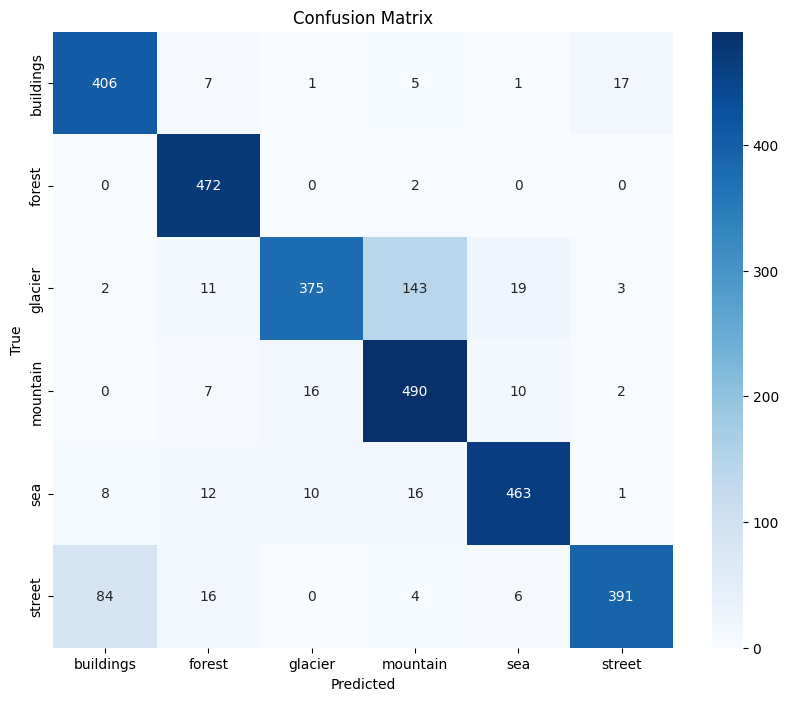

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
print(f'Test Accuracy: {acc:.4f}')
print(report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## 7. Visualize Results:
    Visualize the images and predictions:

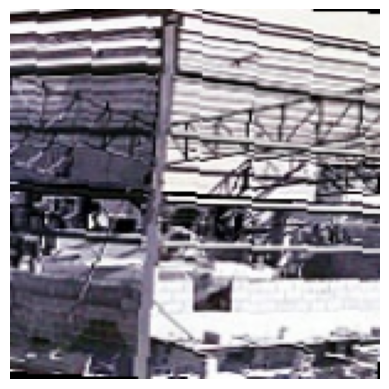

Predicted: buildings | True: buildings


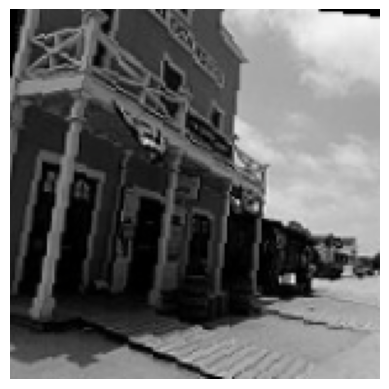

Predicted: street | True: buildings


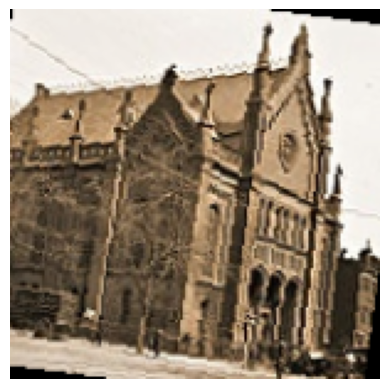

Predicted: buildings | True: buildings


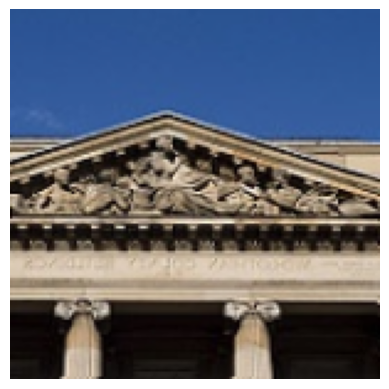

Predicted: buildings | True: buildings


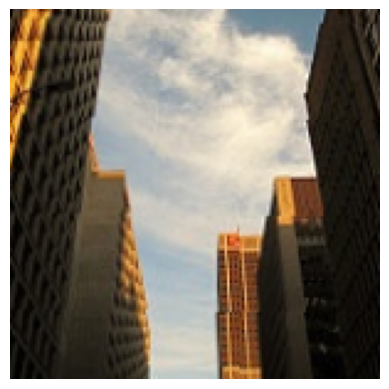

Predicted: buildings | True: buildings


In [28]:
# Define helper function to display images
import numpy as np
def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Test one batch
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Generate 5 random indices
random_indices = torch.randperm(len(images))[:5]

# Visualize 5 random images
for i in random_indices:
    imshow(images[i])
    print(f'Predicted: {train_dataset.classes[preds[i]]} | True: {train_dataset.classes[labels[i]]}')

In [ ]:
# Cell 4: Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

# Evaluate the model
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Visualize sample predictions
def visualize_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'True: {labels[i]}\nPred: {predicted[i]}')
        plt.axis('off')
    plt.show()

visualize_predictions(model, test_loader, device)

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.title('Learning Curves - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined